In [61]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 105)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")

In [99]:
df1=pd.read_csv('qkk.csv')
df1= df1.query('show > 1000')
df2=pd.read_csv('sl.csv')
df = df1.append(df2, ignore_index=True)
print(df.shape)
df.head()

(347128, 4)


,title,show,click,ctr
0,富士康国内赚千亿，华为遭“断供”后带头撤离，郭台铭真“爱国”,1703,986,57.897827
1,华为5G领跑全球，中国移动却将77亿5G订单给外国？看不起华为吗？,2530,1444,57.075099
2,因拒绝高通芯片，这家中国企业差点倒闭，如今大力发展5G打脸美国,3097,1766,57.022925
3,两个日本“首富”，一个更换华为通讯基站，一个准备工厂迁出中国,1880,1065,56.648936
4,东方大国开启万亿级市场，美企巨头全部落选，白宫表示无法接受,1635,923,56.452599


In [100]:
df = df[df.title.apply(lambda x: len(str(x))>5)]
df.sort_values(by=['ctr'],ascending=False,inplace=True)

res= df[['title','ctr']].reset_index(drop=True)
from sklearn.preprocessing import MinMaxScaler
x = res['ctr'].values.astype(float).reshape(-1,1) 
min_max_scaler = MinMaxScaler(feature_range=(0.0, 10.0))
x_scaled = min_max_scaler.fit_transform(x)
print(x_scaled)
res["ctr"]= x_scaled

res.head()

[[1.00000000e+01]
 [9.85786467e+00]
 [9.84885114e+00]
 ...
 [6.65918356e-04]
 [1.83345798e-04]
 [0.00000000e+00]]


,title,ctr
0,富士康国内赚千亿，华为遭“断供”后带头撤离，郭台铭真“爱国”,10.000000
1,华为5G领跑全球，中国移动却将77亿5G订单给外国？看不起华为吗？,9.857865
2,因拒绝高通芯片，这家中国企业差点倒闭，如今大力发展5G打脸美国,9.848851
3,林黛玉不过是替身，这个人才是宝玉真爱，曹雪芹早就言明二人有染,9.826760
4,两个日本“首富”，一个更换华为通讯基站，一个准备工厂迁出中国,9.784240


In [163]:
df.describe()

,ctr
count,338243.000000
mean,15.857839
std,7.475295
min,0.014364
25%,11.440387
50%,15.645954
75%,20.095962
max,57.897827


In [153]:
threshold= 30
neg= df[df.ctr <= threshold]
n=neg.shape[0]
neg.shape

(24098, 4)

In [154]:
pos= df[df.ctr > threshold]
p=pos.shape[0]
print(p/(p+n) , n/(p+n))
pos.shape


0.25349276664291687 0.7465072333570831


(8183, 4)

In [128]:
neg['label'] = 0
pos['label'] = 1

In [129]:
n= neg[['title','label']]
p= pos[['title','label']]
res= pd.concat([n,p]).reset_index(drop=True)
print(res.shape)
res.head()


(56111, 2)


,title,label
0,标致变道撞上劳斯莱斯，车主下车后，第一句话：三者险买了多少,0
1,孙莉马伊琍范冰冰罕见合影曝光，美貌各有千秋，粉丝却吵起来了,0
2,杨利伟出舱时，为何嘴角挂着血丝脸色苍白，到底发生了什么？,0
3,土豪210万的改装车，前后用了一吨废铁，一脚油门半包中华,0
4,“我和渣男前任分手后，他把我的裸照，一元一张公开网售”,0


In [101]:
# save to CSV
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

res = shuffle(res)

tr,te= train_test_split(res, test_size=0.1)
print(tr.shape)
print(te.shape)
tr.reset_index(drop=True,inplace=True)
te.reset_index(drop=True,inplace=True)
tr.to_csv('train.csv',header=False)
te.to_csv('eval.csv',header=False)

# df[['title','label']].to_csv('bert_shuffle.csv')

(312200, 2)
(34689, 2)


# Load bert result
---

In [48]:
df_raw=pd.read_csv('predict_raw.csv',header=None)
df_raw.columns = ['title','label']
print(df_raw.shape)

(67956, 2)


In [92]:
df_res=pd.read_csv('./output_lr/test_results.csv',header=None)
df_res.columns = ['prob1','prob2']
t=df_res.values.tolist()

df_raw['prob']=t

# df_raw['pre_label']= np.argmax(t, axis=1)
df_raw['confident']= [x[1] for x in t]
df_raw['pre_label']= 0
df_raw['pre_label'][df_raw.confident>0.5]=1

# for eval
df_tp= df_raw[(df_raw.label==1) & (df_raw.pre_label==1)]
df_tn= df_raw[(df_raw.label==0) & (df_raw.pre_label==0)]
df_fp= df_raw[(df_raw.label==0) & (df_raw.pre_label==1)]
df_fn= df_raw[(df_raw.label==1) & (df_raw.pre_label==0)]
tp = df_tp.shape[0]
tn = df_tn.shape[0]
fp = df_fp.shape[0]
fn = df_fn.shape[0]
n =df_raw.shape[0]
df_raw.sort_values(by=['confident'],ascending=False,inplace=True)
pd.options.display.max_rows = 4000
df_raw.reset_index().head(1000)

ValueError: Length of values does not match length of index

tp= 395
tn= 12721
fp= 203
fn= 3474
n= 16793
auc= 0.7374435023401417


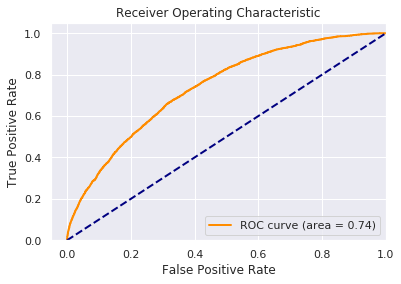

In [133]:
print('tp=',tp)
print('tn=',tn)
print('fp=',fp)
print('fn=',fn)
print('n=',n)
# accuracy = (tp+tn)/n
# precision = tp / (tp+fp)
# recall = tp / (tp+fn)
# F1 = (2*precision*recall) / (precision+recall)
# tpr = tp / (tp+fn)
# fpr = fp / (fp+tn)

# print('accuracy =',accuracy)
# print('precision =',precision)
# print('recall =',recall)
# print('F1 score =',F1)
# print('tpr =',tpr)
# print('fpr =',fpr)
from sklearn import metrics
y=df_raw.label.values
pred= df_raw.confident.values
fpr, tpr, thresholds = metrics.roc_curve(y_true=y, y_score=pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print('auc=', roc_auc)

plt.figure()
linewidth = 2
plt.plot(fpr, tpr, color='darkorange',lw=linewidth, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=linewidth, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

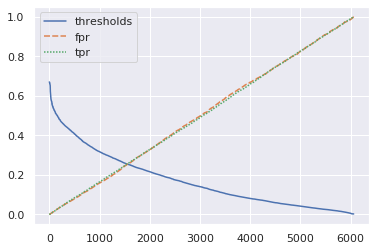

In [105]:
# red dashes, blue squares and green triangles
thresholds= np.array(thresholds.tolist()[1:])
fpr= np.array(fpr.tolist()[1:])
tpr =np.array(tpr.tolist()[1:])

d = {'thresholds': thresholds,'fpr':fpr,'tpr':tpr}
df_roc = pd.DataFrame(data=d)
fig, ax = plt.subplots()
sns.lineplot(data=df_roc)

# idx= range(len(thresholds))
# plt.plot(idx, thresholds, 'g--',idx, tpr, 'r--', idx, fpr, 'b--')
# plt.show()
# sns.lineplot(x="idx", y="fpr",ax= ax,data=df_roc,label='fpr')
# sns.lineplot(x="idx", y="tpr",ax= ax,data=df_roc,label='tpr')
# sns.lineplot(x="idx", y="thresholds",ax= ax,data=df_roc,label='thresholds')

In [247]:
df_raw.query('confident>0.6').head(20)

,title,label,prob,confident,pre_label
1,美国少年敲错门连忙道歉，房主不由分说两枪将其打死辩称是自卫,1,"[0.30041763, 0.69958234]",0.699582,1
4,达成三方交易？29＋15联盟顶级锋线赴休斯顿，哈登：无惧勇士,1,"[0.34201820000000005, 0.6579818000000001]",0.657982,1
8,日本士兵光着膀子耀武扬威，中国老兵一枪毙命，结果日本举国哀痛,1,"[0.37173873, 0.6282612]",0.628261,1
10,中国最难请的四位男星，周星驰只是一般难请，最后一位根本请不动,1,"[0.38571566, 0.61428434]",0.614284,1
15,李姐笑话：小弟弟，姐姐上班要迟到了，你让姐姐坐这辆车行吗,0,"[0.26687646, 0.73312354]",0.733124,1
23,离婚没多久，刘恺威还是原来的刘恺威，杨幂却不再是以前的杨幂,1,"[0.33713812, 0.6628618000000001]",0.662862,1
40,刘备死后，诸葛亮为何不东征为他复仇，反而恢复吴蜀联盟,0,"[0.25788996, 0.7421101]",0.742110,1
42,唐嫣曾为他险些轻生，后又求和被拒绝，如今却爱上60岁的她,1,"[0.38988492, 0.6101151]",0.610115,1
46,他是国家一级演员，二婚娶小37岁娇妻，如今73岁还在挣钱养家,1,"[0.36523387, 0.6347661]",0.634766,1
49,开心笑话：小时候爸爸妈妈总吵架，妈妈说等你考上大学我就离婚,1,"[0.24664576, 0.75335425]",0.753354,1


# Load Regression result

In [86]:
df_raw=pd.read_csv('predict_raw.csv',header=None)
df_raw.columns = ['title','label']
print(df_raw.shape)


(16991, 2)


In [93]:
df_res=pd.read_csv('./output_reg/test_results.csv',header=None)
df_res.columns = ['prob']
t=df_res.values.tolist()

df_raw['prob']=[float(x[0]) for x in t]
df_raw.sort_values(by=['prob'],ascending=False,inplace=True)

df_raw.head(10)


,title,label,prob
4991,甄嬛传：谁注意到？纯元皇后对皇上并非真心，从宜修这句话可看出,3.260279,9.410088
15249,喜气门前绕不停，好运接连进家门的3生肖，财福滚滚！,1.799319,9.083517
10110,羁押3年，江苏前首富终于回归，濒临破产的公司有望拯救了！,6.021923,8.941879
15181,李小龙离世后，难怪他的徒弟立马娶了她的老婆，原因太现实,3.461141,8.827723
3778,农村家家都有的野菜，却可治疗斑疹发热、眼结膜炎、便血、赤痢,2.177002,8.811654
14139,三伏天，吃点红薯好处多，但别与一物同食，却有很多人不清楚,2.321839,8.751305
348,"肾结石好点了?孙宇晨疑回应""被边控"":周五开工",1.009732,8.622917
8548,雍正为何亲定富察氏为弘历嫡福晋？她是真正的白富美,2.720205,8.606672
10733,“地震波还有61秒到达”刷屏……惊叹科技进步之余，我们离地震“预报”还有多远？,2.131961,8.598598
16164,和胡歌搭戏的女演员里她徘徊三四线，被父亲报名参加《非诚勿扰》,2.646193,8.592891


In [89]:

from scipy.stats import pearsonr
r_row, p_value =pearsonr(df_raw.label,df_raw.prob)
print(r_row)

0.832641783917482


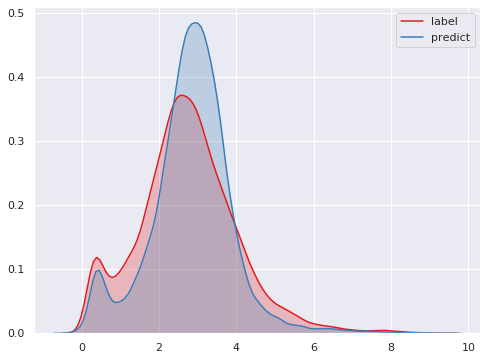

In [98]:
f, ax1 = plt.subplots(1, 1, sharex=False, figsize=(8, 6))
c1, c2, c3 = sns.color_palette('Set1', 3)

sns.kdeplot(df_raw.label, shade=True, color=c1, label='label', ax=ax1)
sns.kdeplot(df_raw.prob, shade=True, color=c2, label='predict', ax=ax1)
